# GP Applied to the Even-Parity Problem

This time we apply GP to a Boolean problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP. 

In [43]:
!pip install deap

In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [45]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp


import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [46]:
# Genetic Programming constants:
POPULATION_SIZE = 2000
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 10


Set the random seed. 

In [47]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [48]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [49]:
NUM_INPUTS = 6
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [50]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []
for row in parityIn:
    parityOut.append(sum(row) % 2)
    
# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

Add our functions and terminals. This time we are using Boolean operators and values.

In [58]:
# create the primitive set:
primitiveSet = gp.PrimitiveSet("main", NUM_INPUTS, "in_")
primitiveSet.addPrimitive(operator.and_, 2)
primitiveSet.addPrimitive(operator.or_, 2)

# add terminal values:
primitiveSet.addTerminal(1)
primitiveSet.addTerminal(0)

Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [59]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=primitiveSet, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=primitiveSet)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitiveSet)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Set up our population as before

In [60]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [61]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size. 

In [56]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	2000  	31.9995	0  	35 	28 	2000  	0.506458	36.056	0  	63 	15 	2000  	19.7206
1  	1780  	31.849 	1  	34 	28 	1780  	0.488056	35.923	1  	93 	9  	1780  	20.0369
2  	1813  	31.785 	2  	34 	28 	1813  	0.552969	37.552	2  	99 	3  	1813  	20.9234
3  	1791  	31.659 	3  	34 	28 	1791  	0.629856	40.52 	3  	105	1  	1791  	21.6602
4  	1815  	31.5475	4  	34 	28 	1815  	0.699102	43.642	4  	117	3  	1815  	22.316 
5  	1829  	31.395 	5  	33 	28 	1829  	0.733468	47.491	5  	119	1  	1829  	21.9846
6  	1806  	31.256 	6  	35 	28 	1806  	0.798413	51.868	6  	153	1  	1806  	21.9247
7  	1807  	31.075 	7  	34 	28 	1807  	0.837481	56.587	7  	167	3  	1807  	21.8917
8  	1805  	30.9515	8  	33 	28 	1805  	0.874727	60.93 	8

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  and_(or_(or_(and_(in_4, and_(in_4, in_0)), and_(in_3, or_(and_(in_5, or_(and_(in_1, in_0), and_(in_1, or_(and_(in_4, in_1), or_(and_(in_0, in_2), or_(in_5, in_1)))))), in_0))), or_(and_(and_(and_(or_(in_5, in_2), or_(in_1, or_(in_5, in_1))), or_(in_4, or_(in_3, in_0))), or_(in_1, or_(and_(in_1, in_0), and_(in_2, in_2)))), and_(or_(in_2, in_4), or_(and_(and_(or_(in_3, or_(in_3, in_1)), or_(or_(in_5, in_3), and_(in_4, in_0))), or_(or_(in_3, or_(or_(in_5, in_1), and_(in_4, in_4))), in_1)), in_3)))), or_(and_(or_(and_(and_(or_(and_(in_2, or_(or_(or_(and_(and_(in_2, in_0), in_4), and_(and_(in_4, in_0), in_2)), and_(in_3, in_3)), or_(or_(in_4, in_4), and_(in_4, in_4)))), or_(in_1, or_(in_1, in_2))), or_(and_(in_4, in_2), or_(or_(and_(in_2, or_(and_(or_(or_(and_(and_(in_2, in_0), in_2), or_(and_(in_3, in_1), or_(in_0, and_(in_3, in_0)))), and_(or_(in_2, in_5), in_1)), in_1), and_(or_(in_1, in_4), or_(in_4, or_(in_0, and_(in_2, in_4)))))), or_(or_(in_0, in_3), in_2)), in_

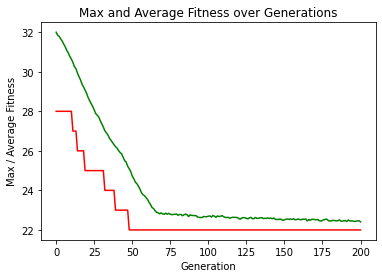

In [57]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best = hof.items[0]
print("-- Best Individual = ", best)
print("-- length={}, height={}".format(len(best), best.height))
print("-- Best Fitness = ", best.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

Now, this looks way more interesting than the Symbolic Regression graph as GP is really being made to work hard here!